In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrotd
import glob

In [2]:
files = glob.glob("PEERNGARecords_Unscaled_S2/*.AT*")

In [3]:
"""import sys
sys.path.append('./REQPY-master/')
from REQPY_Module import REQPY_single, load_PEERNGA_record"""

"import sys\nsys.path.append('./REQPY-master/')\nfrom REQPY_Module import REQPY_single, load_PEERNGA_record"

In [4]:
ground_motions = {}
for fname in files:
    eq_id = fname.split('\\')[-1].split('_')[0]
    if not(eq_id in ground_motions.keys()):
        ground_motions[eq_id] = {'Name':None, 'Date':None, 'Station':None, 'time_step':None, 'Comp':{}}
    with open(fname) as fp:
        next(fp)
        meta01 = next(fp).strip().split(',')
        ground_motions[eq_id]['Name'] = meta01[0].strip()
        ground_motions[eq_id]['Date'] = meta01[1].strip()
        ground_motions[eq_id]['Station'] = meta01[2].strip()
        next(fp)
        ground_motions[eq_id]['time_step'] = float(next(fp)[17:25])
        ground_motions[eq_id]['Comp'][meta01[3]] = np.array([p for l in fp for p in l.split()]).astype(float)

In [5]:
for eqid, data in ground_motions.items():
    for cmp in [' UP',' VRT',' UD',' DWN',' V',' UD']:
        if cmp in data['Comp'].keys():
            del ground_motions[eqid]['Comp'][cmp]

In [6]:
ground_motions.keys()

dict_keys(['RSN1083', 'RSN1614', 'RSN1616', 'RSN1633', 'RSN164', 'RSN286', 'RSN289', 'RSN290', 'RSN313', 'RSN3750', 'RSN3753', 'RSN3757', 'RSN3759', 'RSN3907', 'RSN3926', 'RSN3927', 'RSN3932', 'RSN3948', 'RSN4013', 'RSN4841', 'RSN4843', 'RSN57', 'RSN70', 'RSN740', 'RSN755', 'RSN78', 'RSN827', 'RSN830', 'RSN864', 'RSN881', 'RSN88'])

In [7]:
def read_peer_record(file):
    with open(file) as f:
        f.readline()
        f.readline()
        f.readline()
        dt = np.float(f.readline().split(',')[1].split('=')[1][:9])
        data = []
        for line in f:
            for val in line.strip().split():
                data.append(float(val))
        return dt , np.array(data)

In [8]:
template = open('AbaqusRun2/template.inp','r').readlines()
template_str = ''
for line in template:
    template_str = template_str + line

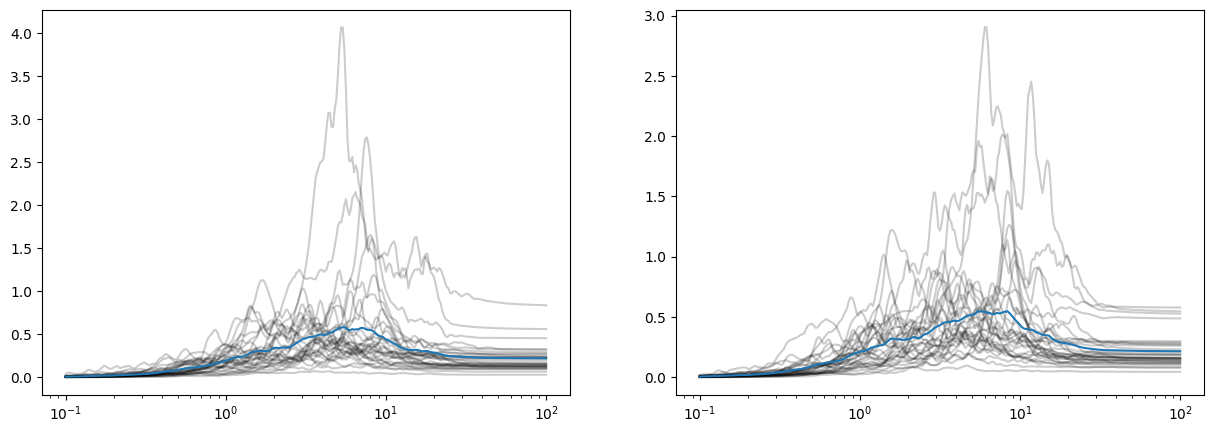

In [9]:
eq_list = ['RSN164','RSN4013','RSN4841','RSN4843','RSN57','RSN70','RSN830','RSN88']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
freq = 10**(np.linspace(-1,2, 301))
xdir_avg = np.zeros(301)
ydir_avg = np.zeros(301)
for eqid, data in ground_motions.items():
    th_key = list(ground_motions[eqid]['Comp'].keys())
    resp_spec_x = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[0]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    resp_spec_y = pyrotd.calc_spec_accels(ground_motions[eqid]['time_step'], ground_motions[eqid]['Comp'][th_key[1]],\
                                          freq, osc_damping=0.05, max_freq_ratio=5, osc_type='psa')
    xdir_avg = xdir_avg + resp_spec_x['spec_accel']/len(ground_motions)
    ydir_avg = ydir_avg + resp_spec_y['spec_accel']/len(ground_motions)
    ax[0].semilogx(freq, resp_spec_x['spec_accel'], c='k', alpha=0.2)
    ax[1].semilogx(freq, resp_spec_y['spec_accel'], c='k', alpha=0.2)
ax[0].semilogx(freq, xdir_avg)
ax[1].semilogx(freq, ydir_avg)

In [10]:
xdir_str = ''
ydir_str = ''
for i in range(301):
    xdir_str = xdir_str + '{0:15.8f}  {1:15.8f}\n'.format(freq[i], xdir_avg[i])
    ydir_str = ydir_str + '{0:15.8f}  {1:15.8f}\n'.format(freq[i], ydir_avg[i])
with open('GenTH/xdir_strR2.RS', 'w') as f:
    f.write(xdir_str)
with open('GenTH/ydir_strR2.RS', 'w') as f:
    f.write(ydir_str)